# Part 3- Prediction

Import all libraries

In [717]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA


pd.options.mode.chained_assignment = None

##  3.1 Write a function called predict_future(‘Region’,’Segment’) which, when called, would perform the following activity:
>1. Predict “Level 5” future values for the next 6 months, given the parameters of the function. (Please make sure the parameters have default values in place) Also, plot it.
>2. Generates the MAPE and RMSE of your prediction of the year 2022, 2021 & 2020 for the given parameters.  

Plot a line graph of the level 5 actual numbers from 2020-2022 & in the same graph, there should be the predicted numbers for 2023. The x-axis should be the timeline from 2020 Jan to 2023 Jun and the y-axis should be the value of the level 5 column and predicted values. You may use Rolling Average and ARIMA for forecasting. (link for reference: 
https://youtu.be/jiQM93dmUek)



Load the data

In [718]:
# Reading the dataset
df = pd.read_csv("../data/createdDataFrame.csv")
df["Value"] = df["Value"]*100000
# Displaying the data
df.head()

,Year,Month,Segment,Region,KPI,Value Type,Value
0,2020,12,Clients,India,Lv1_Visitors,Actuals,3665558.0
1,2020,12,Clients,India,Lv2_Visitors,Actuals,2689569.0
2,2020,12,Clients,India,Lv3_Visitors,Actuals,1300571.0
3,2020,12,Clients,India,Lv4_Visitors,Actuals,717608.0
4,2020,12,Clients,India,Lv3_Visitors,Actuals,706677.0


### 3.1.1 Predict “Level 5” future values for the next 6 months, given the parameters of the function. (Please make sure the parameters have default values in place) Also, plot it.

In [719]:
# select level_5 values from data
df_lv5 = df[df["KPI"]=="Lv5_Visitors"]
df_lv5.shape

(324, 7)

In [723]:
def predict_future(region="Faridabad",segment="Customers"):

    # filtering the data based on region and segment
    df_region_segment = df_lv5[(df_lv5["Region"]==region) & (df_lv5["Segment"]==segment)]

    # Creating a time series from the data
    df_region_segment["Date"] = pd.to_datetime(df_region_segment[["Year","Month"]].assign(day=1))
    
    # Selecting relevant columns
    df_region_segment = df_region_segment[["Date","Value"]]

    # Grouping the values based on Date
    df_region_segment = df_region_segment.groupby(by="Date").sum()

    # Splitting data in train and test set
    train_set = df_region_segment[df_region_segment.index<"2022-07-01"]
    test_set = df_region_segment[df_region_segment.index>="2022-07-01"]

    # Using auto arima to train the model
    model = pm.auto_arima(train_set.Value,
                        seasonal=False,
                        test='adf',
                        stepwise=True, trace=False)

    # Forecasting the values
    n_periods = 6 # number of values to predict
    forecast, confint = model.predict(n_periods=n_periods, return_conf_int=True)

    # Plotting the data
    plt.figure(figsize=(12,5))
    plt.plot(train_set.Value, label="Training")
    plt.plot(forecast, color='darkgreen', label="Forecast")
    plt.plot(test_set, color="orange", label="Actual")
    plt.fill_between(forecast.index, 
                    confint[:,0], 
                    confint[:,1], 
                    color='k', alpha=0.15)

    plt.title(region)
    plt.legend()
    plt.gca().set_ylim(bottom=0)
    plt.show()


    # Calculating the error
    mape = np.mean(np.abs(forecast - test_set.Value)/np.abs(test_set.Value))  # MAPE
    rmse = np.mean((forecast - test_set.Value)**2)**.5  # RMSE

    return ({"MAPE":np.round(mape,3), "RMSE":np.round(rmse,3)})

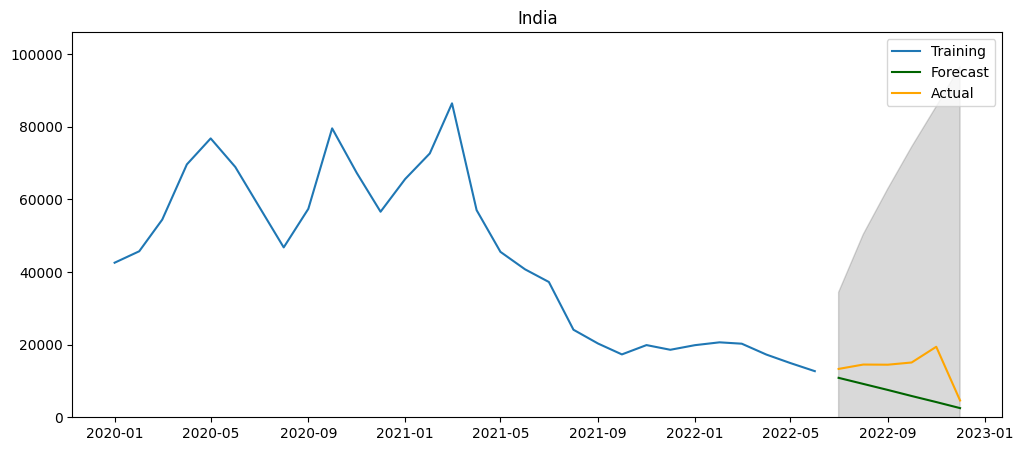

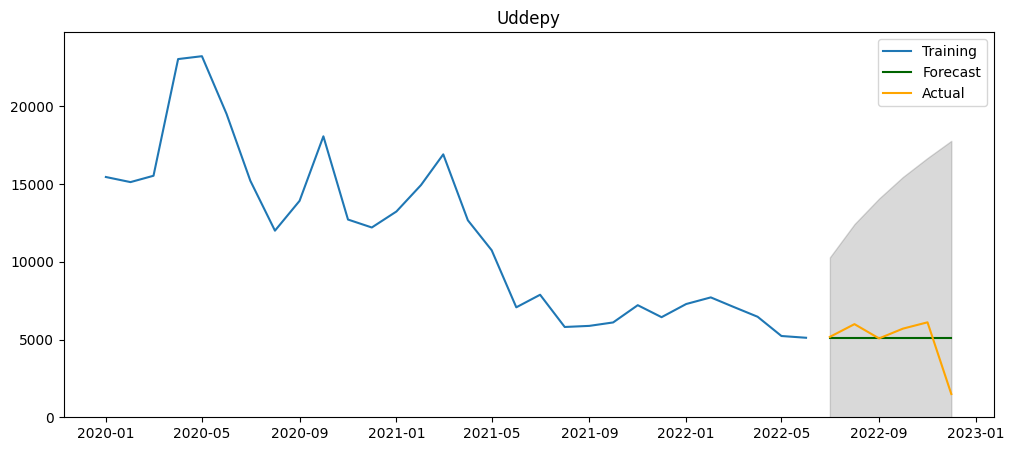

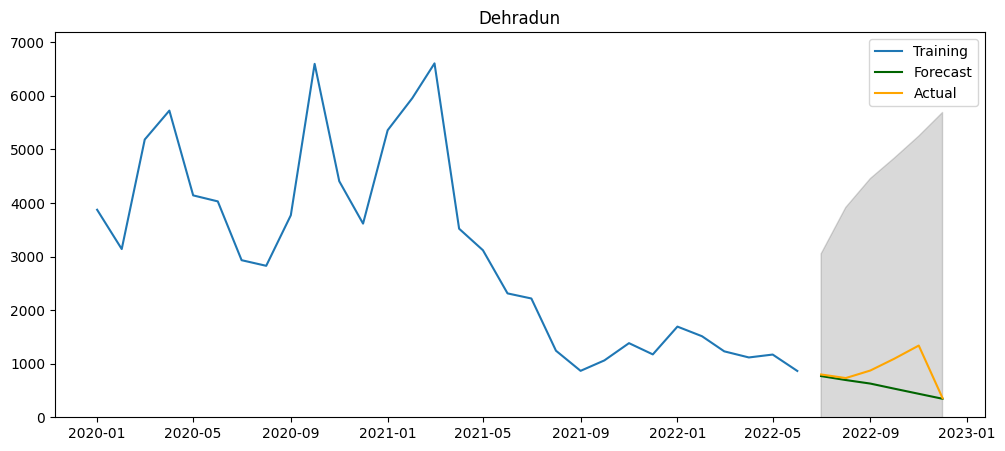

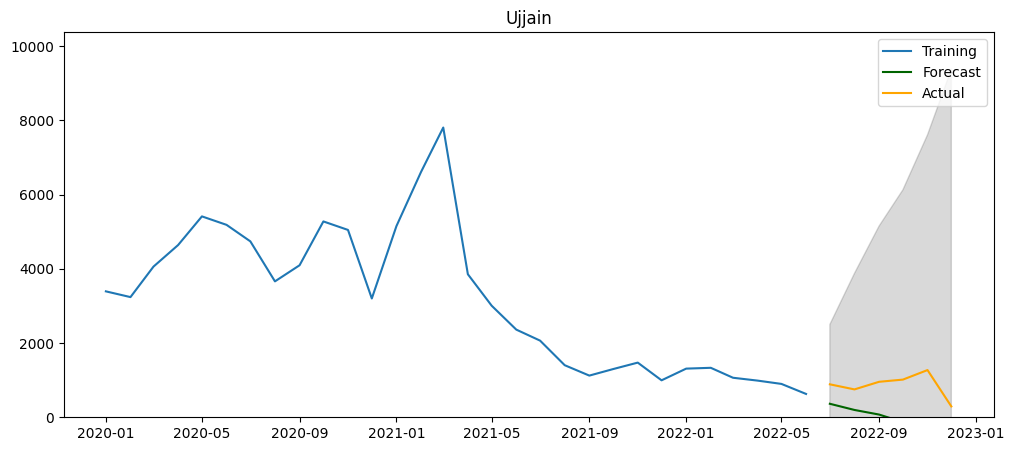

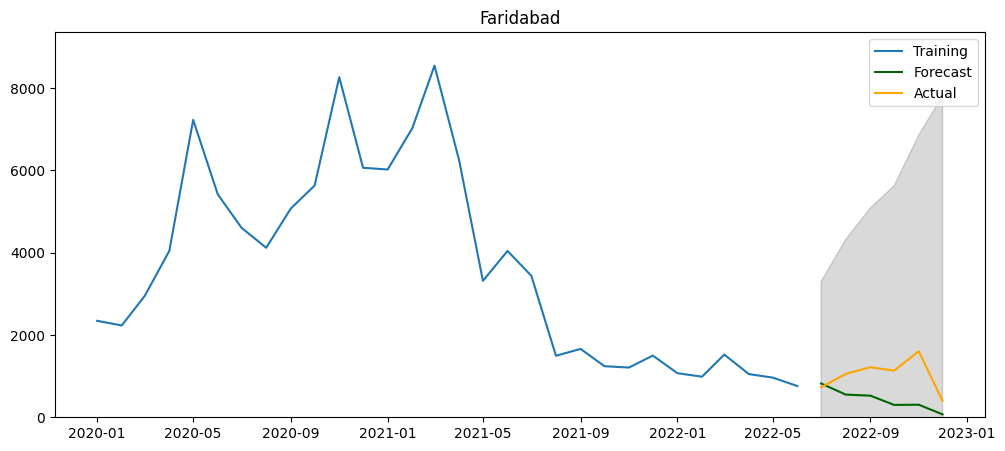

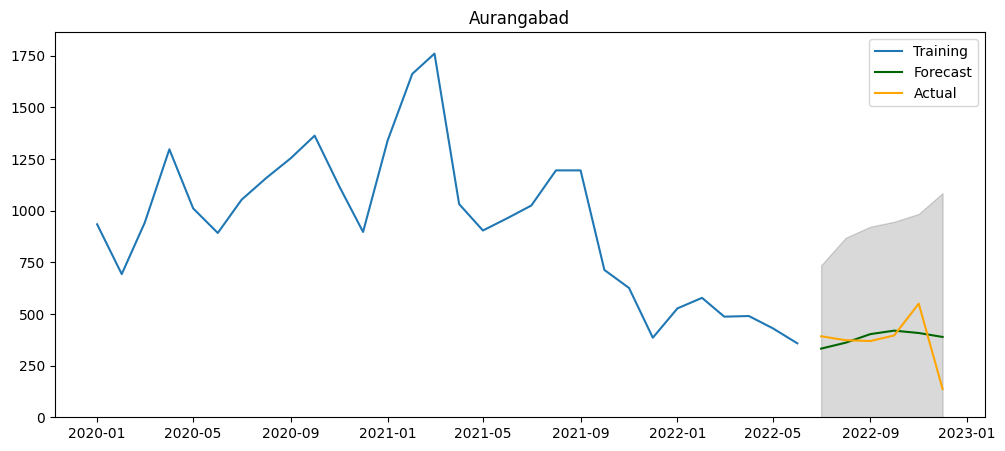

In [724]:
# Selecting all regions from the data
regions = list(df["Region"].unique())

# Setting the segment to customers
segment = "Customers"

# Empty list to store error values
results = []

# loop to generate plots of all regions
for region in regions:
    if df_lv5[(df_lv5["Region"]==region) & (df_lv5["Segment"]==segment)].shape[0] != 0:
        results.append(predict_future(region, segment))

### 3.1.2 Generate the MAPE and RMSE of your prediction

In [727]:
# Displaying the error values
results

[{'MAPE': 0.48, 'RMSE': 8209.474},
 {'MAPE': 0.476, 'RMSE': 1591.97},
 {'MAPE': 0.264, 'RMSE': 444.18},
 {'MAPE': 1.266, 'RMSE': 1007.512},
 {'MAPE': 0.59, 'RMSE': 733.439},
 {'MAPE': 0.405, 'RMSE': 121.774}]